# 데이터 정보 확인

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
df= pd.read_csv('creditcard.csv')
df1= pd.read_csv('creditcard.csv')
df.drop(['Time'], axis = 1, inplace =True)
df1.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<AxesSubplot:xlabel='Amount', ylabel='Density'>

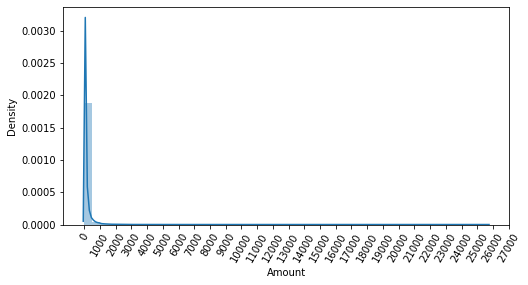

In [30]:
# 'Amount' 분포값 확인

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(df['Amount'])

<AxesSubplot:>

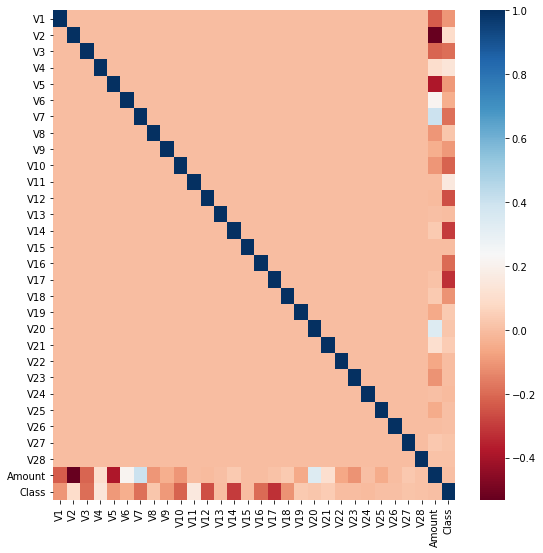

In [31]:
# heatmap을 통한 이상치 확인(v14, v17)

import seaborn as sns

plt.figure(figsize=(9, 9))
corr = df.corr()
sns.heatmap(corr, cmap='RdBu')

In [33]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

outlier_index = get_outlier(df=df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [36]:
import numpy as np
import tensorflow as tf
np.random.seed(3)
tf.random.set_seed(3)


X = df.values[:,0:29]
Y = df.values[:,29]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.15, random_state=42)


In [47]:
from sklearn.ensemble import RandomForestClassifier

# modeling
model_rf = RandomForestClassifier(n_estimators = 15)
# train
model_rf.fit(X_train, Y_train)
# predict
Y_pred = model_rf.predict(X_test)
Y_real = Y_test

In [53]:
accuracy = round(sum(Y_pred == Y_real) / len(Y_pred), 4)
# precision = round(sum([p == 1 & r == 1 for p, r in zip(y_pred, y_real)]) / sum(y_pred == 1), 4)
# recall = round(sum([p == 1 & r == 1 for p, r in zip(y_pred, y_real)]) / sum(y_real == 1), 4)
# f1 = round(2 / ((1/precision) + (1/recall)), 4)

print('Accuracy : ', accuracy)
# print('Precision : ', precision)
# print('Recall : ', recall)
# print('f1-score : ', f1)

Accuracy :  0.9995


In [38]:
# 신경망을 이용한 로지스틱 회귀

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

n_inputs = X_train.shape[1]
n_output = 2

model_nn = tf.keras.Sequential([
    layers.Dense(64, input_shape=(n_inputs, ), activation='tanh'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(n_output, activation='softmax'),
])
model_nn.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nn.summary()

# train
model_nn.fit(X_train, Y_train, batch_size=100, epochs=10, validation_data=(X_test, Y_test))

# predict
y_pred = model_nn.predict(X_test)
y_real = Y_test

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1920      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 34        
Total params: 4,562
Trainable params: 4,562
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2421/2421 [==============================] - 2s 665us/step - loss: 0.0482 - accuracy: 0.9785 - val_loss: 0.0040 - val_accuracy: 0.9992
Epoch 2/10
2421/2421 [==============================] - 1s 571us/step - loss: 0.0037 - accuracy: 0.9993 

In [39]:
y_pred = y_pred.argmax(axis=1)

accuracy = round(sum(y_pred == y_real) / len(y_pred), 4)
print('Accuracy : ', accuracy)
print(classification_report(y_real, y_pred))


Accuracy :  0.9993


NameError: name 'classification_report' is not defined

In [34]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

NameError: name 'get_train_test_dataset' is not defined

# 'Amount' 정규화

In [25]:
import numpy as np
from sklearn.preprocessing import StandardScaler
# StanderScaler로 정규화

scaler = StandardScaler()

# 정규화한 Amount 값을 reshape해서 치환
df[['Amount']] = scaler.fit_transform(df[['Amount']].values.reshape(-1,1))

df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0


<AxesSubplot:xlabel='Amount', ylabel='Density'>

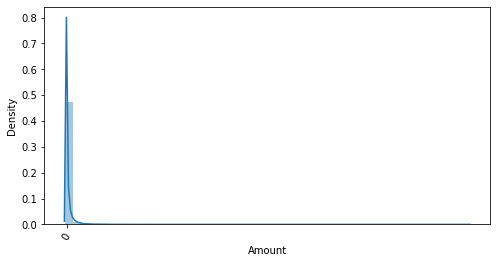

In [27]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(df['Amount'])

# 데이터셋 분리 

In [3]:
import numpy as np
import tensorflow as tf
np.random.seed(3)
tf.random.set_seed(3)


X = df.values[:,0:29]
Y = df.values[:,29]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.15, random_state=42)


# ANN 모델링

Epoch 1/100
1211/1211 [==============================] - 1s 510us/step - loss: 0.1114 - accuracy: 0.97290s - loss: 0.1809 - ac
Epoch 2/100
1211/1211 [==============================] - 1s 506us/step - loss: 0.0037 - accuracy: 0.9994
Epoch 3/100
1211/1211 [==============================] - 1s 507us/step - loss: 0.0028 - accuracy: 0.9994
Epoch 4/100
1211/1211 [==============================] - 1s 506us/step - loss: 0.0025 - accuracy: 0.9994
Epoch 5/100
1211/1211 [==============================] - 1s 492us/step - loss: 0.0023 - accuracy: 0.9995
Epoch 6/100
1211/1211 [==============================] - 1s 491us/step - loss: 0.0023 - accuracy: 0.9995
Epoch 7/100
1211/1211 [==============================] - 1s 499us/step - loss: 0.0022 - accuracy: 0.9994
Epoch 8/100
1211/1211 [==============================] - 1s 492us/step - loss: 0.0022 - accuracy: 0.9995
Epoch 9/100
1211/1211 [==============================] - 1s 485us/step - loss: 0.0020 - accuracy: 0.9995
Epoch 10/100
1211/1211 [=========

Epoch 77/100
1211/1211 [==============================] - 1s 481us/step - loss: 8.1361e-04 - accuracy: 0.9998
Epoch 78/100
1211/1211 [==============================] - 1s 477us/step - loss: 4.4817e-04 - accuracy: 0.99990s - loss: 4.0562e-04 - accura
Epoch 79/100
1211/1211 [==============================] - 1s 479us/step - loss: 6.6827e-04 - accuracy: 0.9998
Epoch 80/100
1211/1211 [==============================] - 1s 476us/step - loss: 5.4596e-04 - accuracy: 0.9999
Epoch 81/100
1211/1211 [==============================] - 1s 477us/step - loss: 5.5274e-04 - accuracy: 0.9998
Epoch 82/100
1211/1211 [==============================] - 1s 476us/step - loss: 5.1438e-04 - accuracy: 0.9999
Epoch 83/100
1211/1211 [==============================] - 1s 484us/step - loss: 4.8112e-04 - accuracy: 0.9998
Epoch 84/100
1211/1211 [==============================] - 1s 481us/step - loss: 4.1238e-04 - accuracy: 0.9999
Epoch 85/100
1211/1211 [==============================] - 1s 481us/step - loss: 5.6423e-04

[0.007590140216052532, 0.9992977976799011]

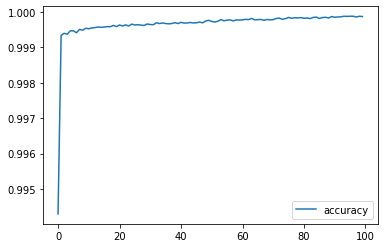

In [4]:
import matplotlib.pyplot as plt

# 모델생성 0 : 활성화 함수 relu, sigmoid를 이용한 ANN 모델링
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu", input_dim=(X_train.shape[1])))
model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs = 100, batch_size=200, verbose=1)

plt.plot(history.history['accuracy'])
plt.legend(['accuracy'])

model.evaluate(X_test, Y_test)

# DNN 모델링

In [5]:
# 모델생성 1 : 활성화 함수 relu, softmax
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(30, activation="relu", input_dim=(X_train.shape[1])))
model.add(tf.keras.layers.Dense(52, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation ='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train, Y_train, epochs = 150, batch_size=20, verbose=1)


Epoch 1/150
12105/12105 [==============================] - 6s 445us/step - loss: 0.0488 - accuracy: 0.9902
Epoch 2/150
12105/12105 [==============================] - 5s 443us/step - loss: 0.0034 - accuracy: 0.9994
Epoch 3/150
12105/12105 [==============================] - 5s 435us/step - loss: 0.0029 - accuracy: 0.9995
Epoch 4/150
12105/12105 [==============================] - 5s 436us/step - loss: 0.0026 - accuracy: 0.9994
Epoch 5/150
12105/12105 [==============================] - 5s 443us/step - loss: 0.0025 - accuracy: 0.9994
Epoch 6/150
12105/12105 [==============================] - 5s 441us/step - loss: 0.0026 - accuracy: 0.9994
Epoch 7/150
12105/12105 [==============================] - 5s 447us/step - loss: 0.0022 - accuracy: 0.9994
Epoch 8/150
12105/12105 [==============================] - 5s 446us/step - loss: 0.0022 - accuracy: 0.9995
Epoch 9/150
12105/12105 [==============================] - 5s 450us/step - loss: 0.0021 - accuracy: 0.9995
Epoch 10/150
12105/12105 [===========

KeyboardInterrupt: 

In [ ]:
# 모델생성 2 : 활성화 함수 relu, sigmoid
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(30, activation="relu", input_dim=(X_train.shape[1])))
model.add(tf.keras.layers.Dense(52, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train, Y_train, epochs = 1000, batch_size=200, verbose=1)


In [ ]:
# 모델생성 3 : 활성화 함수 relu, sigmoid 은닉층 추가
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu", input_dim=(X_train.shape[1])))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train, Y_train, epochs = 1000, batch_size=200, verbose=1)


In [ ]:
# 모델생성 3 : 활성화 함수 relu, sigmoid  은닉층 두 개 추가
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu", input_dim=(X_train.shape[1])))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train, Y_train, epochs = 1000, batch_size=200, verbose=1)


In [ ]:
import matplotlib.pyplot as plt

# 모델생성 3 : 활성화 함수 relu, sigmoid 은닉층 추가
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu", input_dim=(X_train.shape[1])))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs = 100, batch_size=200, verbose=1)

plt.plot(history.history['accuracy'])
plt.legend(['accuracy'])

model.evaluate(X_test, Y_test)

In [ ]:
import matplotlib.pyplot as plt

# 모델생성 3 : 활성화 함수 relu, sigmoid 은닉층 추가
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(32, activation="relu", input_dim=(X_train.shape[1])))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs = 100, batch_size=200, verbose=1)

plt.plot(history.history['accuracy'])
plt.legend(['accuracy'])

model.evaluate(X_test, Y_test)
model.summary(X_test, Y_test)